# Итоговая лабораторная работа.
Создание модели прогнозирования для датасета finance_dataset.csv

Данные состоят из столбцов: Возраст, Доход, Сумма кредита, Кредитный рейтинг и Сбережения, на основе которых отображается Финансовое положение человека.

Данные в файле:

Age - Возраст

Income - Доход

Loan_Amount - Сумма кредита

Credit_Score - Кредитный рейтинг

Savings - Сбережения

Financial_Status - Финансовый статус (финансовое положение человека)

______

Medium 68%
High 16%
Low 16%

In [172]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score

## Чтение данных

In [173]:
data = pd.read_csv('finance_dataset.csv')

In [174]:
data.head()

,Age,Income,Loan_Amount,Credit_Score,Savings,Financial_Status
0,44,40607.526348,9496.572495,340.971402,11784.427355,Medium
1,38,36472.502685,8166.647185,327.250718,14438.107413,Medium
2,46,43013.094695,7326.960308,430.648580,13205.439458,Medium
3,55,55552.090235,12159.168444,557.483446,16771.707794,High
4,37,42985.892657,4419.834649,421.208116,13252.171820,Medium


## 1. Выбор и обоснование метрики для измерения качества.

В рамках данного пункта необходимо подобрать наиболее релевантную метрику или набор метрик для вашей задачи,написав краткое обоснование (1-2 предложения).


*1.1. Предложена метрика*

У нас задача классификации и несбалансированные данные Medium 68%, High 16%, Low 16%, наиболее подходящей метрикой будет F1-Score.

*1.2. Присутствует корректное обоснование*

Она учитывает как точность (precision), так и полноту (recall) классификационного анализа, что крайне полезно в ситуациях, когда классы могут быть несбалансированными.

F1-Score - позволяет оценить качество модели, принимая в расчет как положительные предсказания, так и те, которые модель пропустила. В нашем случае важно минимизировать как ложноположительные, так и ложноотрицательные предсказания, что она и отражает.

## Проведен EDA на своих данных.

В рамках данного пункта необходимопровести предварительный разведочный анализ своего набора данных.


*2.1. Рассмотрены базовые характеристики / статистики для набора данных*

In [175]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               10000 non-null  int64  
 1   Income            10000 non-null  float64
 2   Loan_Amount       10000 non-null  float64
 3   Credit_Score      10000 non-null  float64
 4   Savings           10000 non-null  float64
 5   Financial_Status  10000 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 468.9+ KB


In [176]:
data.describe()

,Age,Income,Loan_Amount,Credit_Score,Savings
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,39.471600,39539.270265,7869.394462,394.337426,11861.075046
std,10.034095,11176.446815,2859.085902,111.737256,4227.035929
min,0.000000,-5870.521902,-4413.548098,-45.601580,-2806.465367
25%,33.000000,31977.344018,5940.594698,321.087650,9005.807348
50%,39.000000,39548.826519,7861.191088,394.810537,11901.008258
75%,46.000000,46944.517948,9805.969439,468.373110,14739.029967
max,79.000000,83970.013942,18051.454859,860.749295,29350.301755


std - стандартное отклонение

Проверка на наличие пропущенных значений

In [177]:
data.isnull().sum()

,0
Age,0
Income,0
Loan_Amount,0
Credit_Score,0
Savings,0
Financial_Status,0


Financial_Status Значения, количество, процент

In [178]:
column = "Financial_Status"
unique_counts = data[column].value_counts()
total_count = len(data[column])
print(f"\nСтолбец '{column}':")
for value, count in unique_counts.items():
    percentage = (count / total_count) * 100
    print(f"Значение: '{value}', Количество: {count}, Процент: {percentage:.2f}%")



Столбец 'Financial_Status':
Значение: 'Medium', Количество: 6820, Процент: 68.20%
Значение: 'High', Количество: 1593, Процент: 15.93%
Значение: 'Low', Количество: 1587, Процент: 15.87%


Дальше проверим как распределяются финансовые статусы по возрастам

In [179]:
# Словарь для хранения рамок для каждого значения Financial_Status
age_ranges = {}

for status in data['Financial_Status'].unique():
    # Фильтруем данные по текущему статусу
    filtered_data = data[data['Financial_Status'] == status]

    # Находим минимум и максимум в столбце Age
    min_age = filtered_data['Age'].min()
    max_age = filtered_data['Age'].max()

    # Сохраняем результаты в словаре
    age_ranges[status] = (min_age, max_age)

for status, (min_age, max_age) in age_ranges.items():
    print(f"Для статуса '{status}': Возрастные рамки: {min_age} - {max_age}")

Для статуса 'Medium': Возрастные рамки: 30 - 49
Для статуса 'High': Возрастные рамки: 50 - 79
Для статуса 'Low': Возрастные рамки: 0 - 29


Убираем всех с Income < 0 и Loan_Amount < 0, так как отрицательное значение Дохода и Суммы кредита не может быть. Иначе это уже будут не кредиты, а вклады!

Можно их расценить как "аномалии" - Доход отрицательный либо невозможен, либо долги строго превышают доход, что по сути должно быть в отдельной колонке. А отрицательный кредит - можно расценить как Вклады. И Усреднение их значений может ввести в заблуждение.

Так же при возрасте до 18 лет кредит дать не могут!

Их всего 33 из 10000, для обучения конкретной модели их лучше - Удалить! для обеспечения более чистого набора данных.

In [180]:
data = data[(data['Income'] >= 18) & (data['Income'] >= 0) & (data['Loan_Amount'] >= 0)]

In [181]:
data.describe()

,Age,Income,Loan_Amount,Credit_Score,Savings
count,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000
mean,39.553326,39622.208134,7899.556061,395.177698,11884.630339
std,9.941710,11090.488042,2814.512230,110.887648,4210.145400
min,3.000000,1119.837630,77.135481,-7.851588,-2806.465367
25%,33.000000,32055.873468,5966.605313,321.951759,9044.808132
50%,40.000000,39609.681890,7869.314740,395.223533,11912.972241
75%,46.000000,46976.276194,9820.389664,468.663791,14750.200353
max,79.000000,83970.013942,18051.454859,860.749295,29350.301755


In [182]:
data = data.reset_index()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9967 entries, 0 to 9966
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             9967 non-null   int64  
 1   Age               9967 non-null   int64  
 2   Income            9967 non-null   float64
 3   Loan_Amount       9967 non-null   float64
 4   Credit_Score      9967 non-null   float64
 5   Savings           9967 non-null   float64
 6   Financial_Status  9967 non-null   object 
dtypes: float64(4), int64(2), object(1)
memory usage: 545.2+ KB


Проверка дубликатов

In [183]:
data.duplicated().any()

False

In [184]:
# Проверим частичные дубликаты по выбранным столбцам
partial_duplicates = data.duplicated(subset=['Age', 'Income', 'Loan_Amount', 'Credit_Score', 'Savings'], keep=False)

# Выведем строки с частичными дубликатами
duplicate_rows = data[partial_duplicates]

# Печать количества частичных дубликатов и самих дубликатов
print(f"Количество частичных дубликатов: {duplicate_rows.shape[0]}")
print(duplicate_rows)

Количество частичных дубликатов: 0
Empty DataFrame
Columns: [index, Age, Income, Loan_Amount, Credit_Score, Savings, Financial_Status]
Index: []


Дубликатов нет

2.2. Реализованы наиболее релевантные визуализации

In [185]:
import seaborn as sns
import matplotlib.pyplot as plt

Гистограмма распределения

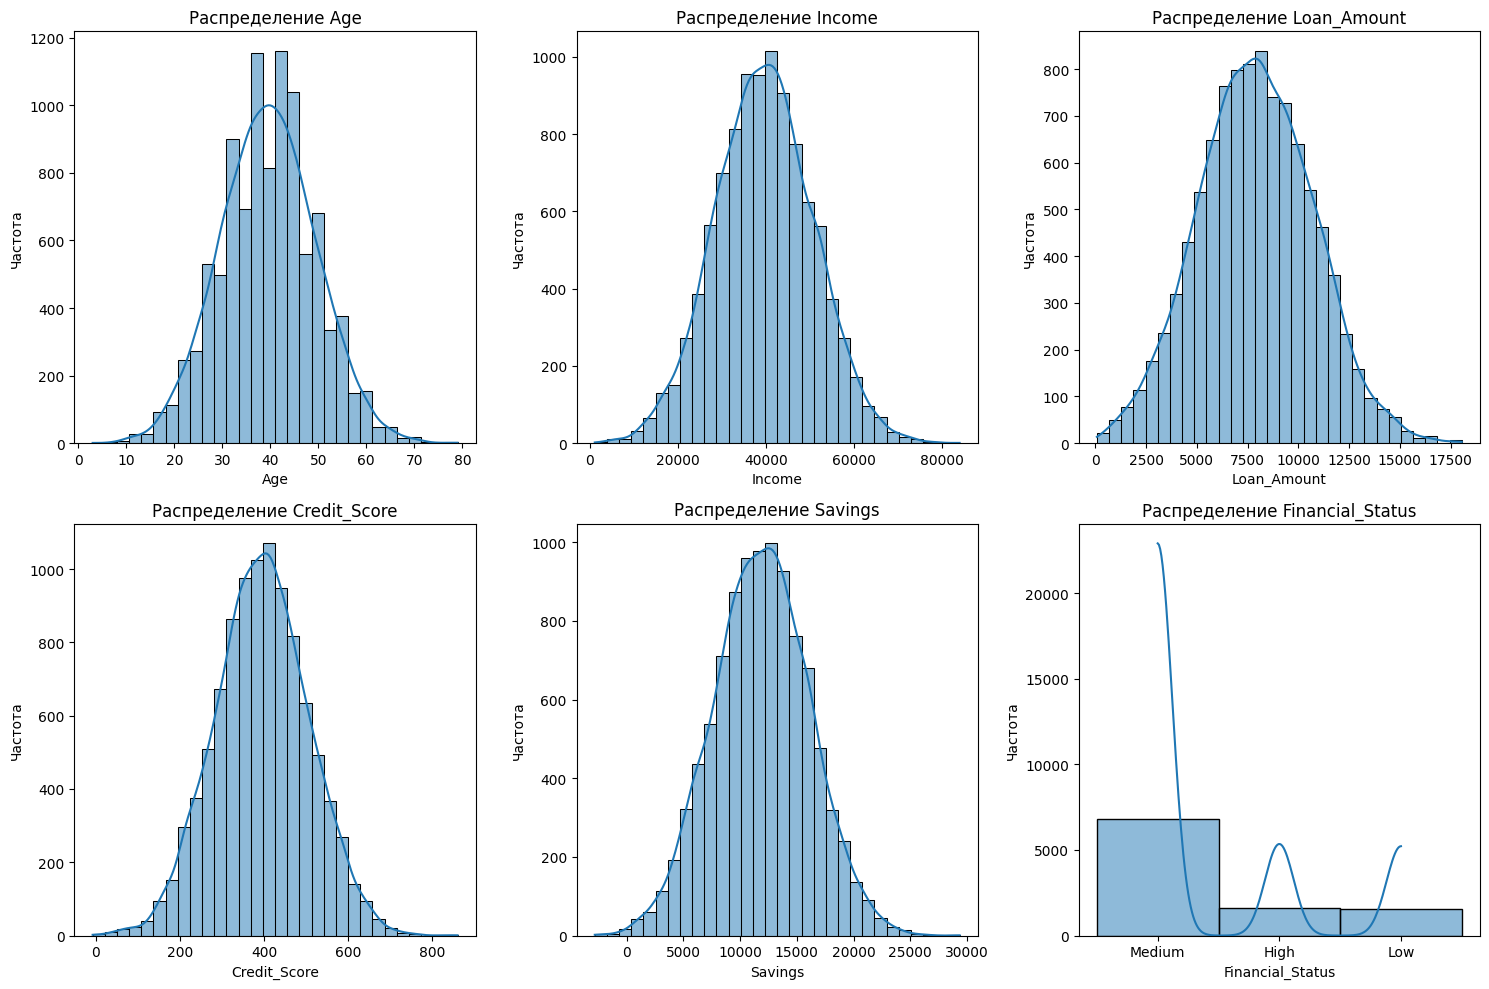

In [186]:
n_cols = 3 # Столбцы
n_rows = (len(data.columns) - 1 + n_cols - 1) // n_cols  # Строки

# Создание фигуры и сетки подграфиков
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()  # Выравнивае массива подграфиков

# Визуализация распределение для каждого столбца
for i, column in enumerate(data.columns[1:]):  # Пропускаем первый столбец index
    sns.histplot(data[column], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Распределение {column}")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Частота")

# Удаление лишних подграфиков, 2 пустых подграфика
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Проверка, что элементы не налезают друг на друга
plt.show()


Визуализация зависимостей от Financial_Status

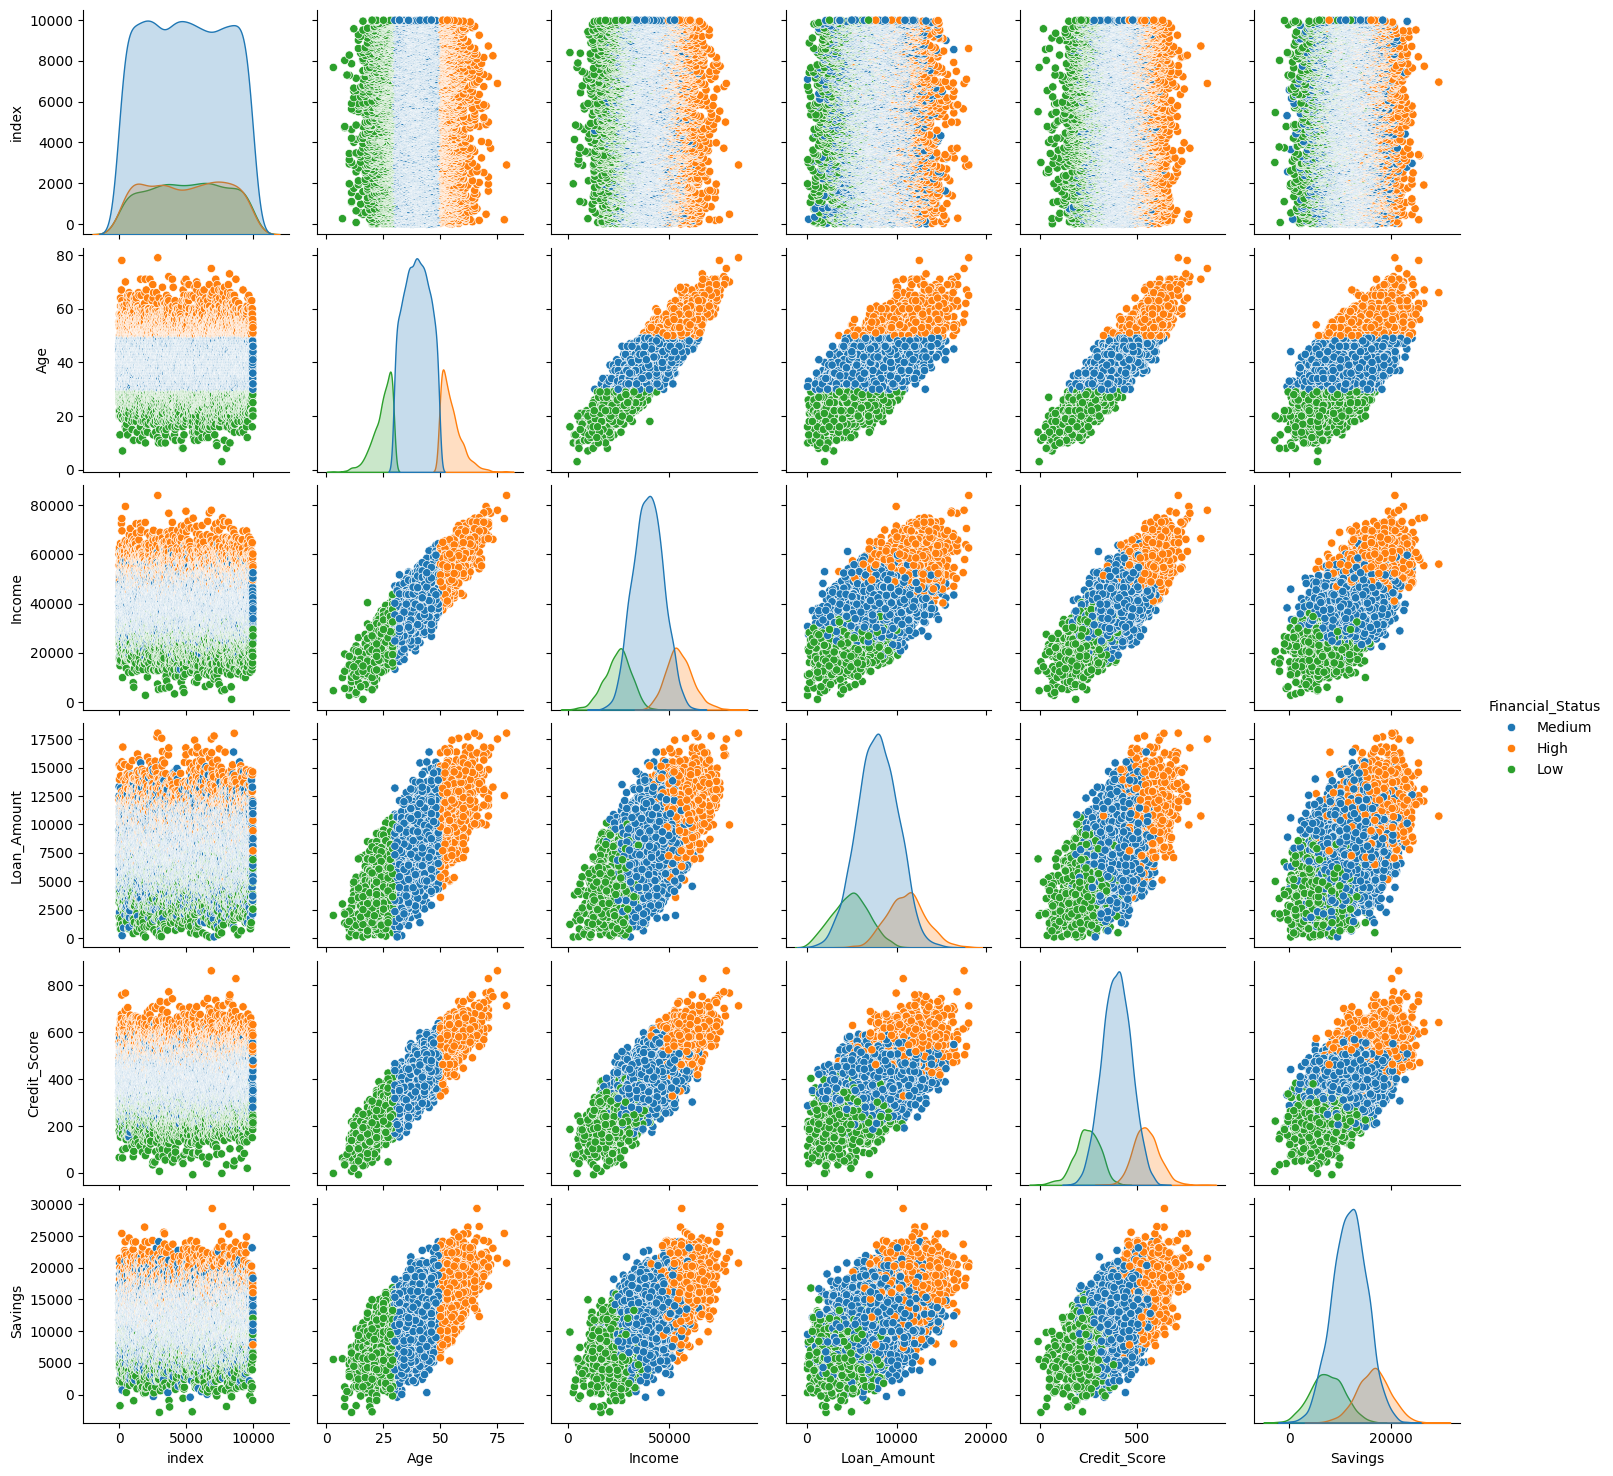

In [187]:
# Визуализация зависимостей
sns.pairplot(data, hue='Financial_Status')
plt.show()

Матрица Зависимостей (Матрица Корреляций)

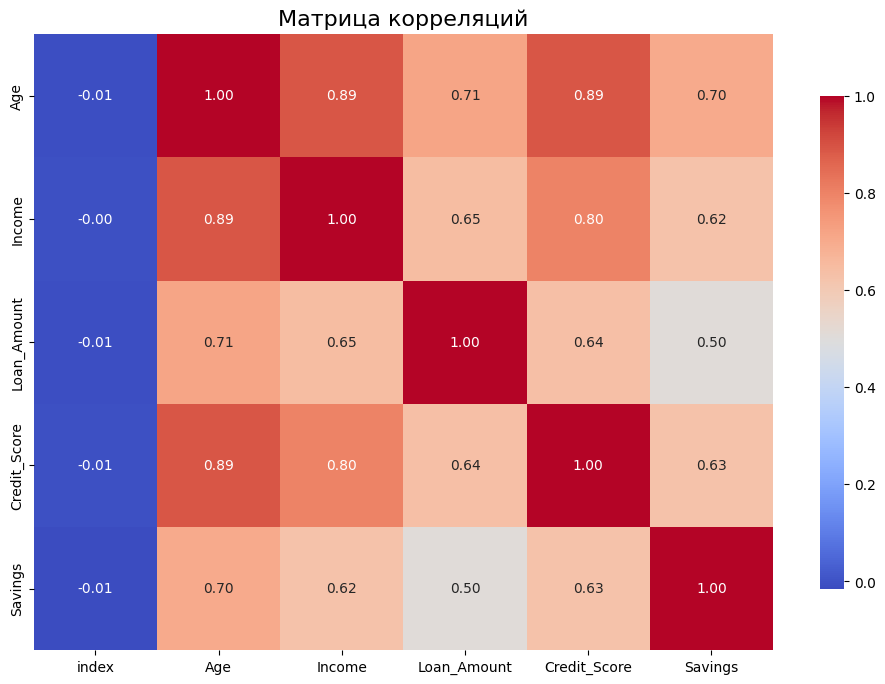

In [188]:
# Удалим категориальные столбцы для анализа
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Вычисление
correlation_matrix = numeric_data.corr()

# Визуализация
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix[1:], annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Матрица корреляций', fontsize=16)
plt.show()


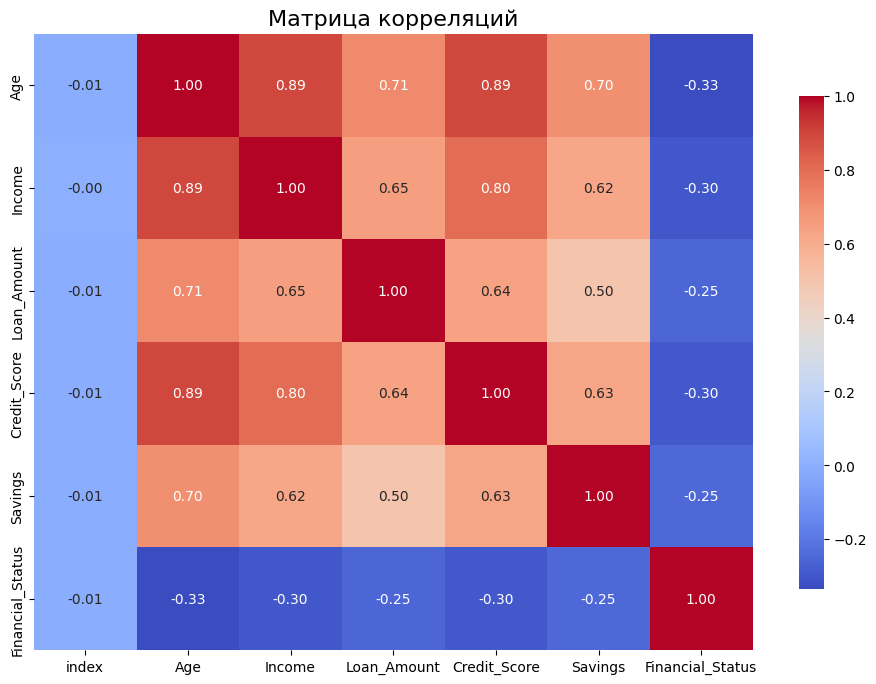

In [189]:
from sklearn.preprocessing import LabelEncoder

# Создаем копию, чтобы провести анализ и не затронуть изначальные данные
data_correlation_matrix = data.copy()

# Преобразование категориальных данных
label_encoder = LabelEncoder()
data_correlation_matrix['Financial_Status'] = label_encoder.fit_transform(data['Financial_Status'])

# Вычисление корреляции
correlation_matrix = data_correlation_matrix.corr()

# Визуализация
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix[1:], annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Матрица корреляций', fontsize=16)
plt.show()


In [190]:
# Словарь для хранения рамок для каждого значения Financial_Status
age_ranges = {}

for status in data['Financial_Status'].unique():
    # Фильтруем данные по текущему статусу
    filtered_data = data[data['Financial_Status'] == status]

    # Находим минимум и максимум в столбце Age
    min_age = filtered_data['Age'].min()
    max_age = filtered_data['Age'].max()

    # Сохраняем результаты в словаре
    age_ranges[status] = (min_age, max_age)

for status, (min_age, max_age) in age_ranges.items():
    print(f"Для статуса '{status}': Возрастные рамки: {min_age} - {max_age}")

Для статуса 'Medium': Возрастные рамки: 30 - 49
Для статуса 'High': Возрастные рамки: 50 - 79
Для статуса 'Low': Возрастные рамки: 3 - 29


## 3. Построено и оценено качество бейзлайна

### Определяем признаки и целевую переменную

Для статуса 'Medium': Возрастные рамки: 30 - 49
Для статуса 'High': Возрастные рамки: 50 - 79
Для статуса 'Low': Возрастные рамки: 0 - 29

Он слишком разграничен.

Стоит пренебречь возрастом Age для обучения, иначе некорректно будет определяться статус в новых данных.

In [191]:
# Определяем признаки (X) и целевую переменную (y)
X = data[['Age', 'Income', 'Loan_Amount', 'Credit_Score', 'Savings']]
y = data['Financial_Status']

Для наглядности  рассмотрим модель Random Forest не исключая Age

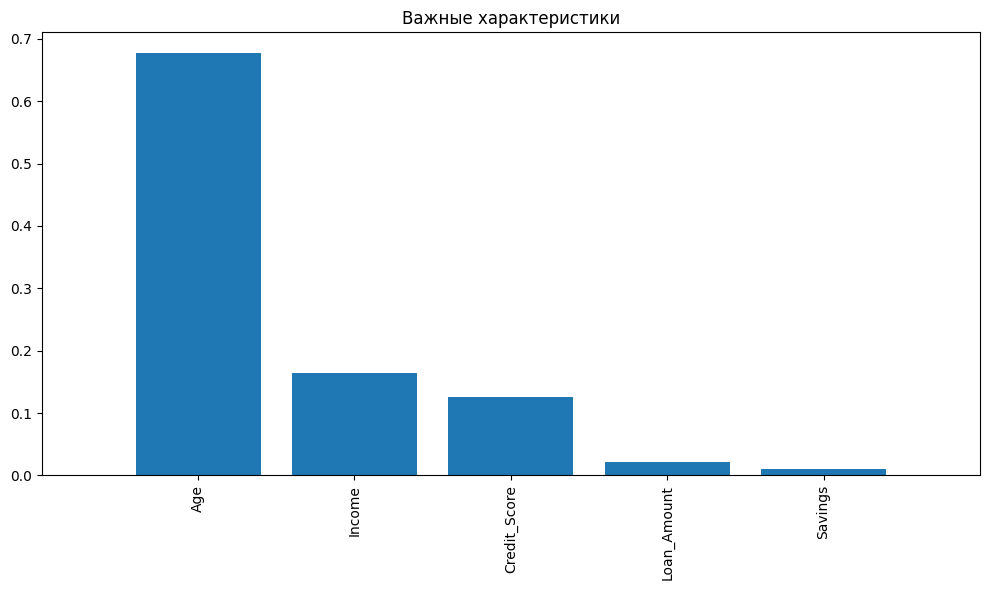

F1-Score: 1.0


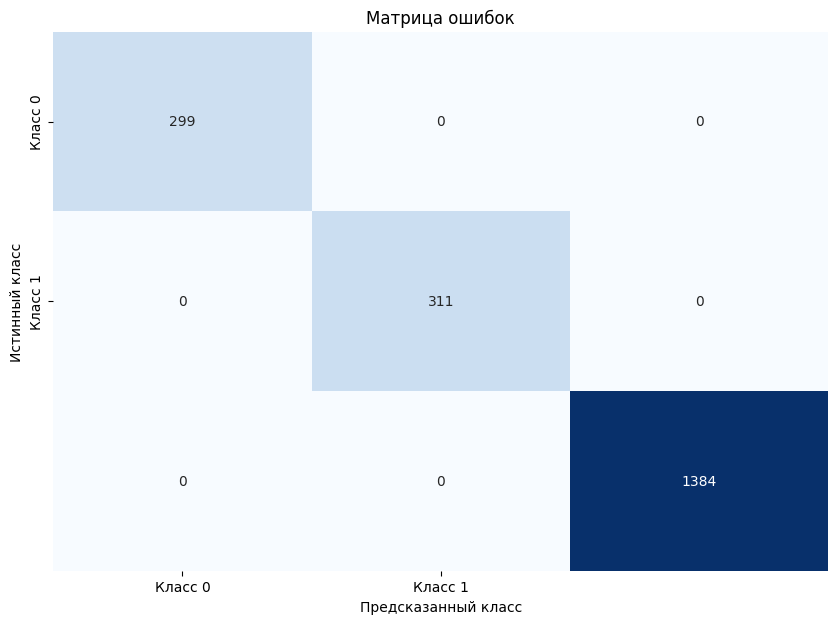

In [192]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

# Определяем признаки (X) и целевую переменную (y)
X = data[['Age', 'Income', 'Loan_Amount', 'Credit_Score', 'Savings']]
y = data['Financial_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Получаем важности признаков
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_train.columns

# Визуализация важностей признаков
plt.figure(figsize=(10, 6))
plt.title('Важные характеристики')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

# Прогнозирование
y_pred = model.predict(X_test)

# F1-Score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1-Score: {f1}')

# Создание матрицы ошибок
cm = confusion_matrix(y_test, y_pred)
# Визуализация матрицы ошибок
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Класс 0', 'Класс 1'], yticklabels=['Класс 0', 'Класс 1'])
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.show()


Устанавливаем нулевое значение в переменную Age, тем самым поставив эту переменную как незначащую, иначе модель слишком быстро привыкает к

Для статуса 'Medium': Возрастные рамки: 30 - 49

Для статуса 'High': Возрастные рамки: 50 - 79

Для статуса 'Low': Возрастные рамки: 0 - 29

И всегда приписывает соответсвующий статус к этим группам возрастов, в этих данных это работает, а вот в новых - будут несоответствия.

Проблема в том, что он имеет не 70% значимости, а буквально забирает всю значимость.

In [193]:
X.loc[:, 'Age'] = 0  # Устанавливаем нулевое значение для Age

### 3.1. Произведено измерение качества константного предсказания. 3.2. Бейзлайновая модель обучена на тренировочной выборке.

Мода - наиболее часто встречающееся решение. Это Безлайн Решение!

In [194]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [195]:
# Бейзлайновое предсказание (по моде)
most_frequent_class = data['Financial_Status'].mode()[0]
y_pred_baseline = [most_frequent_class] * len(y_test)

# F1-Score
f1 = f1_score(y_test, y_pred_baseline, average='weighted')
print(f'F1-Score: {f1}')

F1-Score: 0.5596158272677724


## 4. Построена более сложная модель с подбором гиперпараметров

4.1. Выбрана более сложная ML-модель. 4.2. Произведено измерение качества на отложенной выборке.

Используем Кросс-валидацию с использованием GridSearchCV

In [196]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Random Forest Будет лучше всего на 1/1000, а Переобучать приходится долго = Не стоит того.

In [197]:
# Нормализация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)  # Используем DataFrame

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Словарь для хранения моделей
models = {
    # "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=3000, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

# Словарь для хранения параметров для каждой модели
param_grids = {
    # "Random Forest": {
    #     'n_estimators': [50, 150, 200, 250, 300], # Количество деревьев в лесу
    #     'max_depth': [10, 20], # Максимальная глубина деревьев (На сколько могут делиться)
    #     'min_samples_split': [2, 5, 7, 10], # Минимальное количество объектов, необходимых для разделения узла
    #     'min_samples_leaf': [1, 2, 4] # Минимальное количество объектов в листьях (последние узлы дерева)
    # },
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10, 100, 1000], # Регуляризующий параметр (чем меньше значение (0.01), тем сильнее регуляризация (отсеивает менее важные признаки, предотвращения переобучения модели)) (добавляет дополнительное ограничение (штраф) к функции потерь)
        'solver': ['liblinear', 'saga'],  # Алгоритмы оптимизации для решения задачи liblinear (малым и средним объемом данных, эффективна для задач логистической регрессии), saga (быстрее, поддерживает L1 и L2 регуляризацию)
        'penalty': ['l1', 'l2', 'elasticnet'], # Тип регуляризации
    },
    "Decision Tree": {
        'max_depth': [None, 5, 10, 15, 20, 25], # Максимальная глубина дерева (На сколько могут делиться)
        'min_samples_split': [2, 5, 10, 15], # Минимальное количество объектов для разделения узла
        'min_samples_leaf': [1, 2, 3, 4, 5, 7, 10], # Минимальное количество объектов в листьях
    },
    "K-Nearest Neighbors": {
        'n_neighbors': [1, 3, 5, 7, 10, 15, 20, 30], # Количество соседей, используемых для классификации
        'weights': ['uniform', 'distance'],  # Способ взвешивания соседей (равные веса uniform или пропорционально расстоянию distance)
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], # Алгоритмы для поиска соседей
        'leaf_size': [10, 20, 30, 40], # Размер листа в KNN, который влияет на скорость поиска
    }
}

# Хранение лучших моделей и их F1-Score
best_models = {}
best_f1_scores = {}
training_times = {}  # Словарь для хранения времени обучения
best_params = {}  # Словарь для сохранения лучших гиперпараметров

# Подбор параметров для каждой модели
for model_name, model in models.items():
    print(f"Подбор параметров для {model_name}...")
    start_time = time.time()  # Время начала

    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], scoring='f1_weighted', cv=5, verbose=3, refit=True)
    grid_search.fit(X_train, y_train)

    end_time = time.time()  # Время окончания
    training_time = end_time - start_time  # Время обучения

    # Сохраняем лучшие результаты
    best_models[model_name] = grid_search.best_estimator_
    best_f1_scores[model_name] = f1_score(y_test, best_models[model_name].predict(X_test), average='weighted')
    training_times[model_name] = training_time  # Сохраняем время обучения
    best_params[model_name] = grid_search.best_params_  # Сохраняем лучшие гиперпараметры

    print(f"Лучшие гиперпараметры для {model_name}: {grid_search.best_params_}")
    print(f'F1-Score для {model_name}: {best_f1_scores[model_name]}')
    print()


Подбор параметров для Logistic Regression...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.880 total time=   0.1s
[CV 2/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.893 total time=   0.1s
[CV 3/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.882 total time=   0.1s
[CV 4/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.888 total time=   0.1s
[CV 5/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.895 total time=   0.1s
[CV 1/5] END ...C=0.01, penalty=l1, solver=saga;, score=0.045 total time=   3.4s
[CV 2/5] END ...C=0.01, penalty=l1, solver=saga;, score=0.045 total time=   3.3s
[CV 3/5] END ...C=0.01, penalty=l1, solver=saga;, score=0.045 total time=   4.8s
[CV 4/5] END ...C=0.01, penalty=l1, solver=saga;, score=0.045 total time=   3.7s
[CV 5/5] END ...C=0.01, penalty=l1, solver=saga;, score=0.047 total time=   3.5s
[CV 1/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.670 total tim

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/u

Лучшие гиперпараметры для Logistic Regression: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
F1-Score для Logistic Regression: 0.8758214494159934

Подбор параметров для Decision Tree...
Fitting 5 folds for each of 168 candidates, totalling 840 fits
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.836 total time=   0.1s
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.833 total time=   0.1s
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.840 total time=   0.1s
[CV 4/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.840 total time=   0.1s
[CV 5/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.839 total time=   0.1s
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=5;, score=0.837 total time=   0.1s
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=5;, score=0.838 total time=   0.1s
[CV 3/5] END max_depth=None, mi

Лучшие гиперпараметры для каждой модели

In [198]:
print("\nЛучшие гиперпараметры для каждой модели:")
for model_name, params in best_params.items():
    print(f"{model_name}: {params}")


Лучшие гиперпараметры для каждой модели:
Logistic Regression: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Decision Tree: {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}
K-Nearest Neighbors: {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 30, 'weights': 'distance'}


Время обучения

In [199]:
print("Время обучения моделей:")
for model_name, time_taken in training_times.items():
    print(f"{model_name}: {time_taken:.2f} секунд")

Время обучения моделей:
Logistic Regression: 217.03 секунд
Decision Tree: 58.29 секунд
K-Nearest Neighbors: 135.03 секунд


Лучшие модели и F1-Score

In [200]:
print("\nЛучшие модели и F1-Score:")
for model_name, f1 in best_f1_scores.items():
    print(f"{model_name}: {f1}")


Лучшие модели и F1-Score:
Logistic Regression: 0.8758214494159934
Decision Tree: 0.8628720706988551
K-Nearest Neighbors: 0.8507655581355852


Графическое распределение результатов

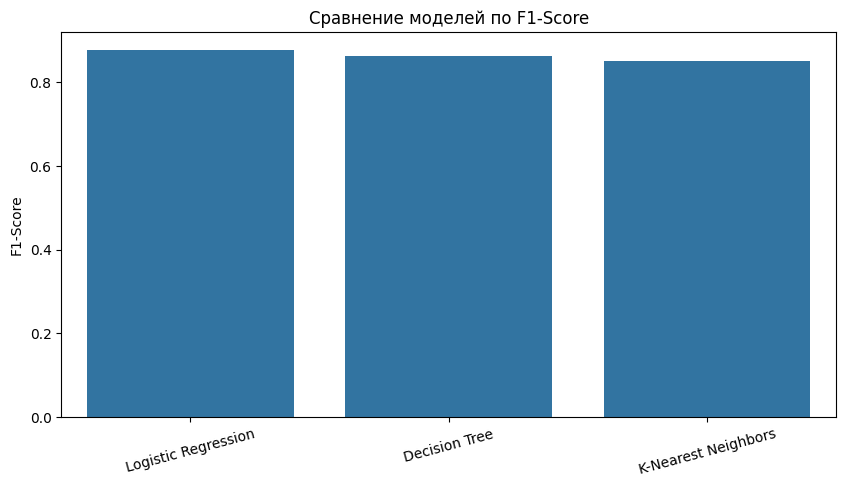

In [201]:
# Визуализация результатов
plt.figure(figsize=(10, 5))
sns.barplot(x=list(best_f1_scores.keys()), y=list(best_f1_scores.values()))
plt.ylabel('F1-Score')
plt.title('Сравнение моделей по F1-Score')
plt.xticks(rotation=15)
plt.show()

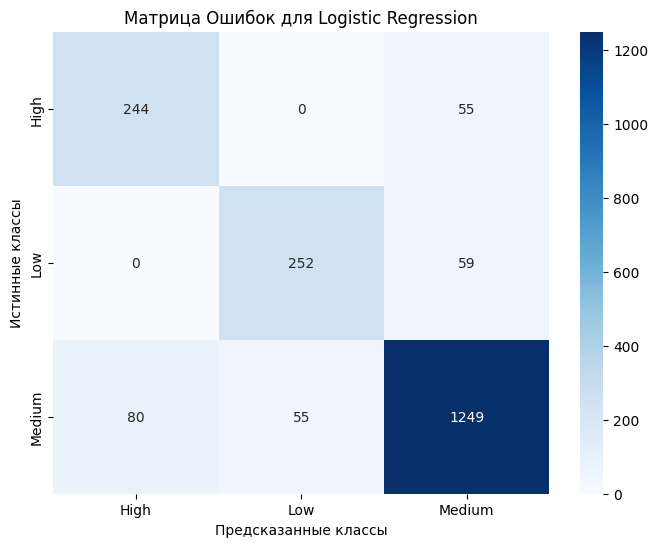

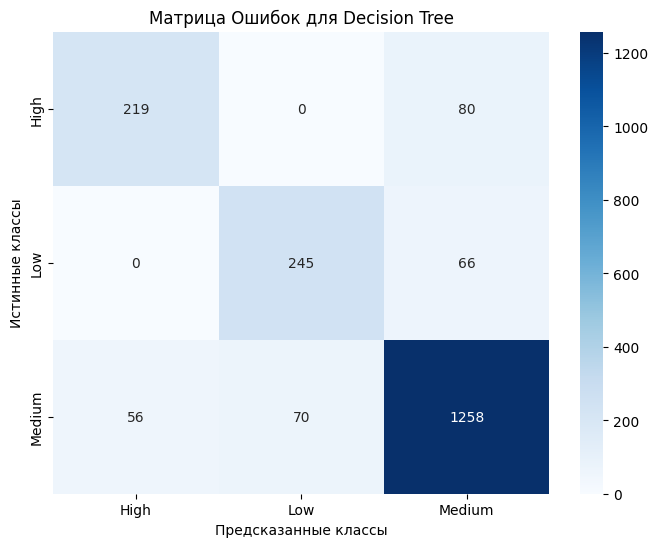

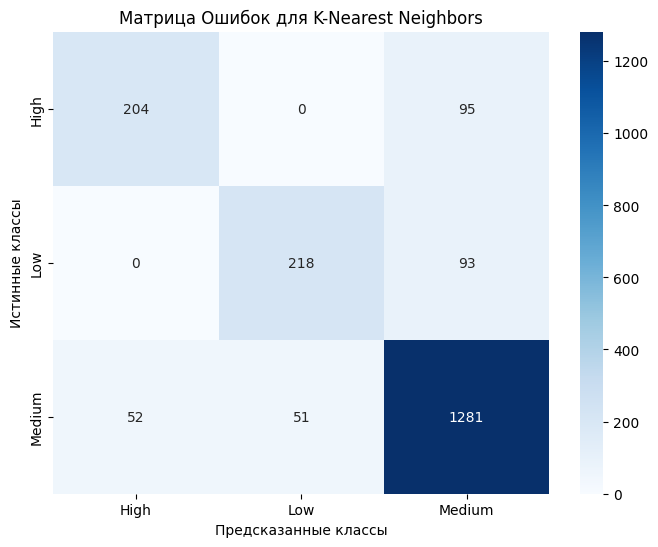

In [202]:
# Визуализация матриц ошибок
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f'Матрица Ошибок для {model_name}')
    plt.xlabel('Предсказанные классы')
    plt.ylabel('Истинные классы')
    plt.show()


## Сохранение модели

In [203]:
from joblib import dump

In [204]:
# Сохранение лучшей модели по F1-Score
best_model_name = max(best_f1_scores, key=best_f1_scores.get)
best_model = best_models[best_model_name]
dump(best_model, 'finance_model.joblib')

print(f"Лучшая модель {best_model_name} сохранена как 'finance_model.joblib'")

Лучшая модель Logistic Regression сохранена как 'finance_model.joblib'


# Проверка на новых входных данных (Здесь же, но есть и отдельная программа)

In [208]:
from joblib import load

# Загрузка модели из файла
loaded_model = load('finance_model.joblib')
print("Модель успешно загружена!")

# Пример использования загруженной модели для предсказания
# Создаем DataFrame с признаком и правильными именами

sample_data = pd.DataFrame([[22, 26114, 5445, 65, 5320]],
                            columns=['Age', 'Income', 'Loan_Amount', 'Credit_Score', 'Savings'])

predicted_status = loaded_model.predict(sample_data)
print("Предсказанный финансовый статус:", predicted_status)


Модель успешно загружена!
Предсказанный финансовый статус: ['Low']
